# Project 3 - CAM을 만들고 평가해 보자

**목표**
- ResNet50 + GAP + DenseLayer 결합된 CAM 모델 구현
- CAM 방식과 Grad-CAM 방식의 class activation map 시각화
- CAM과 Grad-CAM의 object localization 성능 비교분석

In [11]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import os
import copy
import cv2
from PIL import Image

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### (1) 데이터 준비

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='~/aiffel/tensorflow_datasets'
)

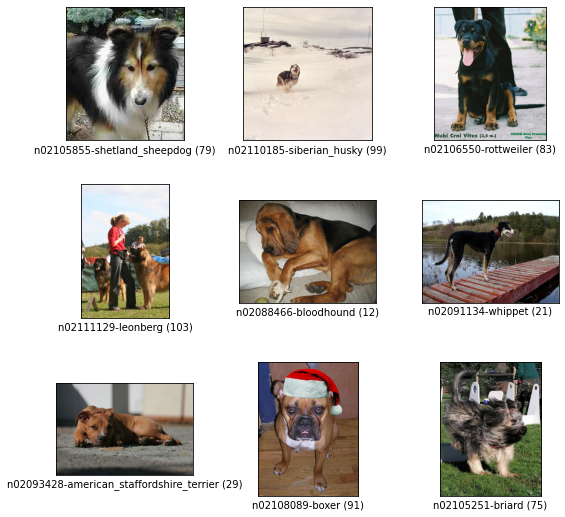

In [6]:
_ = tfds.show_examples(ds_train, ds_info)

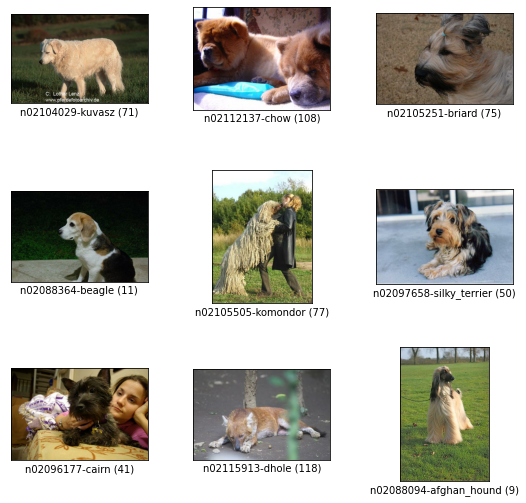

In [13]:
_ = tfds.show_examples(ds_test, ds_info)

### (2) 데이터 전처리

In [15]:
def normalize_and_resize_img(data):
    image = tf.image.resize(data['image'], (224, 224))
    data['image'] = tf.cast(image, tf.float32) / 255.
    return data['image'], data['label']

In [ ]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch

### (3) ResNet 사전 학습 모델 불러오기